In [ ]:
# !pip install SimpleITK

In [ ]:
#import packages
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
import SimpleITK as sitk
import cv2 as cv
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools

plt.ion()  

In [ ]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

# Preparing Data

In [ ]:
#bias_correction: get the MR image and return the bias corrected image as a result
def bias_correction(image):
    corrector = sitk.N4BiasFieldCorrectionImageFilter(); #define a N4 bias corrector
    input_img = sitk.GetImageFromArray(np.copy(image)) #convert the numpy arry to 
    maskImage = sitk.OtsuThreshold( input_img, 0, 1, 200 ) #Apply Otsu thresholding inorder to get the ROI of image
    input_img = sitk.Cast( input_img, sitk.sitkFloat32 )#Cast image to 'stikfloat32' dtype
    output = corrector.Execute( input_img, maskImage )   #Execute N4 method on image
    corrected_image = sitk.GetArrayFromImage(output)
    corrected_image = (corrected_image-corrected_image.min())/(corrected_image.max()-corrected_image.min()) #Normalizing the result
    return corrected_image

#reshape_image: get the image and resize it to the target size 
def reshape_image(image, size=(299, 299)):
    reshaped_image = cv.resize(image, size, cv.INTER_CUBIC)  #resize input image to 'size' using cubic interpolation  
    return reshaped_image

#crop_image: crop the ROI region and return it
def crop_image(image):
    gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)#convert a RGB image to gray level image
    gray = cv.GaussianBlur(gray, (5, 5), 0) #Apply the gaussian filter inordet to remove the noise


    thresh = cv.threshold(gray, 45, 255, cv.THRESH_BINARY)[1]  #Apply thresholding to get the ROI region
    #the two next line delet the noise from the binary image using the erode and dilate
    thresh = cv.erode(thresh, None, iterations=2)
    thresh = cv.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) 
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv.contourArea)
    
    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # add contour on the image
    img_cnt = cv.drawContours(image.copy(), [c], -1, (0, 255, 255), 4)

    # add extreme points
    img_pnt = cv.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
    img_pnt = cv.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
    img_pnt = cv.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
    img_pnt = cv.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

    # crop
    ADD_PIXELS = 0
    new_img = image[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img
    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
data_path = "/content/drive/My Drive/Lesion_Segmentation/Data" #the path of orginal images
new_path = "/content/drive/My Drive/Lesion_Segmentation/Pre_Data" #the path of preprocced images

width = height = 299

if not os.path.exists(new_path):
  os.mkdir(new_path)


for direc in os.listdir(data_path):
  directory_path = os.path.join(data_path, direc)


  for image_name in os.listdir(directory_path):
    image = cv.imread(os.path.join(directory_path, image_name))
    
    print(f'Processing Image {image_name} start...')

    #Crop Image
    croped_image = crop_image(image)
    print('    Crop Image complete...' , croped_image.shape)

    #Bias Corection
    bias_coreected_image = bias_correction(croped_image)
    print('    Bias Correction complete...')

    #Reshape Image
    reshaped_image = reshape_image(bias_coreected_image, size=(width, height))
    print(f'   Image Reshaped from {image.shape} to {reshaped_image.shape}')

    #Save Image
    file_name = os.path.join(os.path.join(new_path, direc), image_name)
    reshaped_image *= (255.0/reshaped_image.max())
    cv.imwrite(file_name, reshaped_image.astype(np.uint8))
    print('    Saved Image')


##Splite Data

In [ ]:
# split the data by train/val/test
IMG_PATH = '/content/drive/My Drive/Lesion_Segmentation/MRI_DATA/Pre_Data/'
data_folder = '/content/drive/My Drive/Lesion_Segmentation/MRI_DATA/splited_data/'
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, data_folder + 'test/' + CLASS + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, data_folder + 'train/'+ CLASS + '/' + FILE_NAME)
            else:
                shutil.copy(img, data_folder + 'val/'+ CLASS + '/' + FILE_NAME)


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), #crop a random 244 by 24 image from the input image
        transforms.RandomHorizontalFlip(), #apply the flip algorithm randomly
        transforms.ToTensor(), #convert the image to a pytorch tensor
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #normalize the each chanle of image
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),#crop a 244 by 24 image from the input image
        transforms.ToTensor(),#convert the image to a pytorch tensor
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])#normalize the each chanle of image
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),#crop a 244 by 24 image from the input image
        transforms.ToTensor(),#convert the image to a pytorch tensor
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])#normalize the each chanle of image
    ]),

}
batch_size = {'train':8, 'val':8, 'test':1} #define batch_size for each set
data_dir = '/content/drive/My Drive/Lesion_Segmentation/MRI_DATA/splited_data/' #the path of images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']} # define a variable as a dataset for each dataset
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x],
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']} #define a dataloader for each dataset
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    acc_train=[]
    acc_val=[]
    loss_train=[]
    loss_val=[]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

         # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to train mode
            else:
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                 # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                acc_val.append(epoch_acc)
                loss_val.append(epoch_loss)
            else:
                acc_train.append(epoch_acc)
                loss_train.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_train, loss_val, acc_train, acc_val


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model_ft, loss_train, loss_val, acc_train, acc_val = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=40)

In [ ]:
plt.plot(loss_train)

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv, loss_train, loss_val, acc_train, acc_val = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Text(0.5, 1.0, 'Train Accuracy')

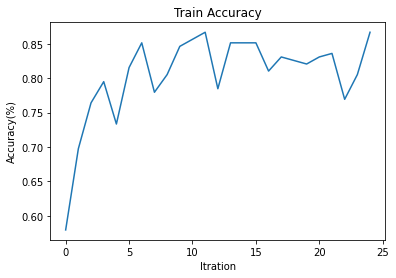

In [ ]:
plt.plot(acc_train)
plt.xlabel('Itration')
plt.ylabel('Accuracy(%)')
plt.title('Train Accuracy')

Text(0.5, 1.0, 'Validation Accuracy')

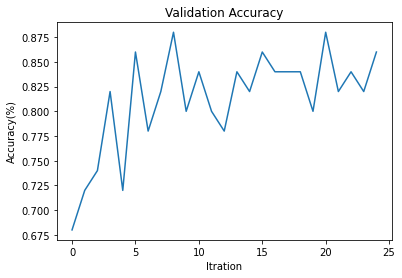

In [ ]:
plt.plot(acc_val)
plt.xlabel('Itration')
plt.ylabel('Accuracy(%)')
plt.title('Validation Accuracy')

Text(0.5, 1.0, 'Train Loss')

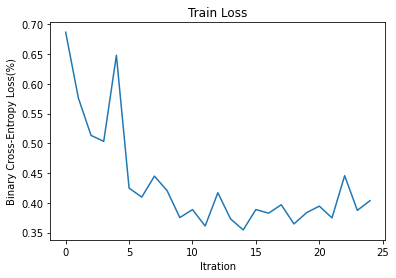

In [ ]:
plt.plot(loss_train)
plt.xlabel('Itration')
plt.ylabel('Binary Cross-Entropy Loss(%)')
plt.title('Train Loss')

Text(0.5, 1.0, 'Validation Loss')

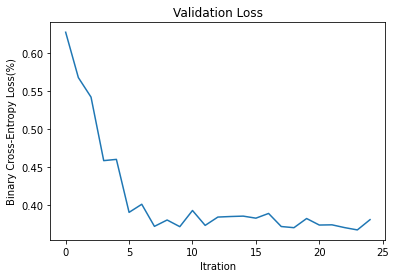

In [ ]:
plt.plot(loss_val)
plt.xlabel('Itration')
plt.ylabel('Binary Cross-Entropy Loss(%)')
plt.title('Validation Loss')

In [ ]:
# test the model
predicted_label = []
label = []
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
  
    outputs = model_conv(inputs)
    _, temp = torch.max(outputs, 1)
    predicted_label.append(int(temp.to('cpu').numpy())+1)
    label.append(int(labels.to('cpu').numpy()))

print(f'The labels are: {label}')
print(f'The predicted labels are: {predicted_label}')

The labels are: [1, 2, 1, 2, 1, 2, 2, 1, 2, 1]
The predicted labels are: [1, 2, 1, 2, 1, 2, 2, 1, 2, 2]


In [ ]:
accuracy = accuracy_score(label, predicted_label)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(label, predicted_label) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(np.unique(label)), normalize=False, title='Test Confusion Matrix')

In [ ]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(224), #crop a random 244 by 24 image from the input image
        transforms.RandomHorizontalFlip(), #apply the flip algorithm randomly
        transforms.ToTensor(), #convert the image to a pytorch tensor
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #normalize the each chanle of image
    ])

data_dir = '/content/drive/My Drive/Lesion_Segmentation/MRI_DATA/Pre_Data/' #the path of images
image_datasets = datasets.ImageFolder(data_dir, transform)
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=False, num_workers=4)
          
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# test the model
predicted_label = []
label = []
for inputs, labels in dataloaders:
    inputs = inputs.to(device)
    labels = labels.to(device)
  
    outputs = model_conv(inputs)
    _, temp = torch.max(outputs, 1)
    predicted_label.append(int(temp.to('cpu').numpy()))
    label.append(int(labels.to('cpu').numpy()))

print(f'The labels are: {label}')
print(f'The predicted labels are: {predicted_label}')

The labels are: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The predicted labels are: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
accuracy = accuracy_score(label, predicted_label)
print('Overall Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(label, predicted_label) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(np.unique(label)), normalize=False, title='Overall Confusion Matrix')